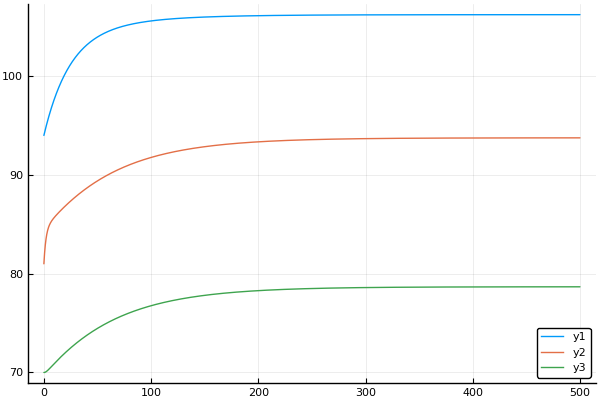

In [27]:
## Kalman filter
#    counter-current heat exchanger of Model 1
#Filename:Kalman-Filter-Model1.ipynb
#Author:Madhusudhan Pandey, USN, EPE
#Date: March 20, 2019
figpath = "C:/Users/pande/Desktop/Desktop/Thesis/ThesisLyx/figures/chapter3/";

using NLsolve
using DifferentialEquations
using Plots
pyplot();# pyplot attributes on backend
using LaTeXStrings;
# Linewidths and styles
LW1 = 2 
LW2 = 1.5
LS1 = :solid
LS2 = :dot
LS3 = :dashdot
LS4 = :dash;
# inputs (need to specify first than parameters as Qdfs is input dependent and considered as parameters)
Twc = 3.8
Ifd = 1055.
It = 5360.
QdFes = 212.
Wdf = 528.
mdw = 53.9
mda = 49.2
u = [Twc, Ifd, It, QdFes, Wdf, mdw, mda]
#Specifying Parameters
pa = 1.01e5 # " Atmospheric pressure , Pa "
#
chpa = 1.15 # " Specific heat capacity air , kJ.kg -1. K -1 # " 
chpw = 4.2 # " Specific heat capacity water , kJ.kg -1. K -1 # " 
chpCu = 0.385 # " Specific heat capacity copper , kJ.kg -1. K -1 # " 
chpFe = 0.465 # " Specific heat capacity iron , kJ.kg -1. K -1 # " 
#
mr = 9260. # " Mass of copper in rotor , kg # " 
ms = 6827. # " Mass of copper in stator , kg # " 
mFe = 71200. # " Mass of iron in stator , kg # " 
#
VhCu = 0.112e-3 # " Specific volume of copper , m3 / kg # " 
VhFe = 0.127e-3 # " Specific volume of iron , m3 / kg # " 
#
Vr = mr*VhCu # " Rotor copper volume , m3 # " 
Vs = ms*VhCu # " Stator copper volume , m3 # " 
VFe = mFe*VhFe # " Stator iron volume , m3 # " 
#
UAr2d = 2.7 # " Heat transfer , rotor copper to air gap , kW / K # " 
UAs2Fe = 20. # " Heat transfer , stator copper to stator iron , kW /K" 
UAFe2a = 14.3 # " Heat transfer , rotor iron to hot air , kW / K # " 
Up=0.88 # "Product of overall heat transfer and perimeter"
#
Hha_o = 0. # " Enthalpy of formation air , kJ / kg " 
HhCu_o = 0. # " Enthalpy of formation copper , kJ / kg # " 
HhFe_o = 0. # " Enthalpy of formation iron , kJ / kg # " 
#
Ta_o = 25. # " Standard state temperature air , C # " 
TCu_o = 25. # " Standard state temperature copper , C # " 
TFe_o = 25. # " Standard state temperature iron , C # " 
#
Rr = 0.16e-3 # " Ohmic resistance , rotor copper , kOhm, at 25 C # " 
Rs = 3.5e-6 # " Ohmic resistance , stator copper , kOhm, at 25 C"
#
aCu = 2.559380892459937
bCu = 0.0011982506064166993
aFe = 0.19724545575725203
bFe = 0.00676358006431966
aa = 3.2822556593357177
ba = 0.0006721070788120142
aw = 3.6394816337401976
bw = 0.0012723320470041624
alphaCu = 0.00404
R = 8.314 # " J.K-1.mol-1 # "
MCu = 63.54 # " Molecular mass of Copper, g/mol"
MFe = 55.84 # "Molecular mass of Iron, g/mol"
Ma = 28.97 # "Molecular mass of Air, g/mol"
Mw = 18.01 # "Molecular mass of Water, g/mol"
Qdfs = 0.8*Wdf
#tuples of parameters
par = [pa,chpa,chpw,chpCu,chpFe,mr,ms,mFe,VhCu,VhFe,
    Vr,Vs,VFe,UAr2d,UAs2Fe,UAFe2a,Hha_o,HhCu_o,
    HhFe_o,Ta_o,TCu_o,TFe_o,Rr,Rs,aCu,bCu,aFe,bFe,aa,ba,aw,bw,alphaCu,R,MCu,
    MFe,Ma,Mw,Qdfs];
Tr0, Ts0, TFe0 = 94., 81., 70.
temp_of_states = Tr0,Ts0,TFe0
# Finding values for Tac, Tad, Tah
function find_air_temperatures(temp_of_states, par)
    Tr, Ts, TFe= temp_of_states
    function f!(F, x)
        Tac,Tad,Tah = x[1], x[2], x[3]
        F[1] = mda*chpa*(Tac-Tad)+UAr2d*(Tr-Tad)+Qdfs
        F[2] = mda*chpa*(Tad-Tah)+UAFe2a*(TFe-Tah)
        # solving for Tac function
        #length span of heat exchanger
        xspan=(0.0,50.0)
        function heat_exchanger!(dT,T,par,t)
            # countercurrent
            #Note that heatexchanger model of bernt lie and that of
            #project description x-direction is opposite so we neglect - sign in the formula here
            #Ta=T[1]; Tw=T[2]
            dT[1]=Up/(chpa*mda)*(T[2]-T[1])
            dT[2]=Up/(chpw*mdw)*(T[2]-T[1])
        end
        #initialGuess=[Tah,Twh]
        initial_guess=[Ta_o,Twc]
        function bc!(residual,T,par,t)
            residual[1]=T[1][1]-Tah
            residual[2]=T[end][2]-Twc
        end
        bvp=BVProblem(heat_exchanger!,bc!,initial_guess,xspan,par)
        sol=solve(bvp, Shooting(Vern7()))
        a,b=sol(50) #solves for Tac,Twc
        c,d=sol(0) #solves for Tah,Twh
        #One equation from BVP
        F[3] = Tac - a
    end
    return nlsolve(f!,temp_of_states).zero #returs Tac, Tad, Tah
end
# Solving ODE
dt=10
t_sim=range(0,stop=500*60,step=dt)
points=length(t_sim)
Tr, Ts, TFe, Tac, Tad, Tah = zeros(points,1),zeros(points,1),zeros(points,1),zeros(points,1),zeros(points,1),zeros(points,1) 
Tr[1], Ts[1], TFe[1] = Tr0, Ts0, TFe0
Tac[1], Tad[1], Tah[1] =  find_air_temperatures([Tr0, Ts0, TFe0], par)
for i = 1:(length(t_sim)-1)
    Tr[i+1]=Tr[i] + dt*(1.1*Rr*Ifd^2-UAr2d*(Tr[i]-Tad[i]))/(mr*chpCu)
    Ts[i+1]=Ts[i] + dt*(3*Rs*It^2-UAs2Fe*(Ts[i]-TFe[i]))/(ms*chpCu)
    TFe[i+1]=TFe[i] + dt*(UAs2Fe*(Ts[i]-TFe[i])-UAFe2a*(TFe[i]-Tah[i])+QdFes)/(mFe*chpFe)
    #temp_of=Tr[i+1], Ts[i+1], TFe[i+1]
    Tac[i+1], Tad[i+1], Tah[i+1]=find_air_temperatures([Tr[i+1], Ts[i+1], TFe[i+1]], par)
end
# Storing in some good names for later use
Tr_ODE_counter_current_model1,Ts_ODE_counter_current_model1,
TFe_ODE_counter_current_model1,Tac_ODE_counter_current_model1,
Tad_ODE_counter_current_model1,
Tah_ODE_counter_current_model1,t_ODE_counter_current_model1 = Tr, Ts, TFe, Tac, Tad, Tah, t_sim
#
plot(t_ODE_counter_current_model1/60,Tr_ODE_counter_current_model1)
plot!(t_ODE_counter_current_model1/60,Ts_ODE_counter_current_model1)
plot!(t_ODE_counter_current_model1/60,TFe_ODE_counter_current_model1)

In [12]:
Tac=zeros(10,1)

10×1 Array{Float64,2}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [16]:
Tac; Tad; Tah=3*ones(10,1)
Tac


3.0